# Reuse code from ml_for_spy_v2_ffill_daily_xgboost.ipynb to import features after getting the latest data from fred_yfinance_data_retrieval.ipynb

In [10]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import seaborn as sns



In [11]:
spy_data = pd.read_csv('data/spy.csv')
spy_data
spy_data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)

spy_data.dtypes
spy_data['Date'] = pd.to_datetime(spy_data['Date'])
spy_data.dtypes
spy_data.dropna(inplace=True)
spy_data
spy_data = spy_data[spy_data['Date'].dt.year >= 2023]
spy_data.dropna(inplace=True)
spy_data

,Date,Close
8315,2023-01-03,3824.139893
8316,2023-01-04,3852.969971
8317,2023-01-05,3808.100098
8318,2023-01-06,3895.080078
8319,2023-01-09,3892.090088
...,...,...
8447,2023-07-14,4505.419922
8448,2023-07-17,4522.790039
8449,2023-07-18,4554.979980
8450,2023-07-19,4565.720215


In [12]:
spy_data['Date'].max()

Timestamp('2023-07-20 00:00:00')

In [13]:
# Importing economic indicators and preparing it for use for analysis
## 1.) Import unemployment rate

unemployment_rate = pd.read_csv('data/unemp_data.csv')
unemployment_rate.dropna()
unemployment_rate

unemployment_rate['Date'] = pd.to_datetime(unemployment_rate['Date'])
unemployment_rate.dtypes
unemployment_rate = unemployment_rate[unemployment_rate['Date'].dt.year >= 2023]
unemployment_rate
## The below method for forward fill will be use on other indicators which are not updated daily ##
# Set the 'Date' column as the index of the 'unemployment_rate' DataFrame
unemployment_rate.set_index('Date', inplace=True)

# Resample the data from monthly to daily frequency and forward fill the missing values
unemp_rate_daily = unemployment_rate['unemp_rate'].asfreq('D', method='ffill')

# Reset the index to include the date column again
unemp_rate_daily = unemp_rate_daily.reset_index()

# Find the last date in the 'spy_data' DataFrame
last_date_spy = spy_data['Date'].max()

# Filter the 'unemp_rate_daily' DataFrame up to the last date in 'spy_data'
unemp_rate_daily = unemp_rate_daily[unemp_rate_daily['Date'] <= last_date_spy]

# Create a date range from the day after the last date in 'unemp_rate_daily' until the last date in 'spy_data'
date_range = pd.date_range(start=unemp_rate_daily['Date'].max() + pd.DateOffset(days=1), end=last_date_spy, freq='D')

# Create a DataFrame with the date range and fill the 'unemp_rate' column with NaN
forward_fill_df = pd.DataFrame({'Date': date_range})
forward_fill_df['unemp_rate'] = np.nan

# Concatenate the 'unemp_rate_daily' DataFrame with the forward fill DataFrame
unemp_rate_daily = pd.concat([unemp_rate_daily, forward_fill_df])

# Forward fill the missing values
unemp_rate_daily['unemp_rate'].fillna(method='ffill', inplace=True)

# Print the extrapolated 'unemp_rate_daily' DataFrame
print(unemp_rate_daily)

unemp_rate_daily[unemp_rate_daily.duplicated()]

         Date  unemp_rate
0  2023-01-01         3.4
1  2023-01-02         3.4
2  2023-01-03         3.4
3  2023-01-04         3.4
4  2023-01-05         3.4
..        ...         ...
44 2023-07-16         3.6
45 2023-07-17         3.6
46 2023-07-18         3.6
47 2023-07-19         3.6
48 2023-07-20         3.6

[201 rows x 2 columns]


,Date,unemp_rate


In [14]:
## 2.) Import AAA vs treasury yield

aaavstreasury = pd.read_csv('data/aaavstreasury.csv')
aaavstreasury.dropna()
aaavstreasury.dtypes
aaavstreasury['Date'] = pd.to_datetime(aaavstreasury['Date'])
aaavstreasury.dtypes
aaavstreasury

aaavstreasury =aaavstreasury[aaavstreasury['Date'].dt.year >= 2023]
aaavstreasury[aaavstreasury.duplicated()]
## 3.) CPI

cpi = pd.read_csv('data/cpi_data.csv')
cpi.dropna()
cpi.dtypes
cpi['Date'] = pd.to_datetime(cpi['Date'])
cpi.dtypes
cpi
cpi = cpi[cpi['Date'].dt.year >= 2023]

cpi.set_index('Date', inplace=True)
cpi_daily = cpi['cpi'].asfreq('D', method='ffill')
cpi_daily = cpi_daily.reset_index()
print(cpi_daily)


last_date_spy = spy_data['Date'].max()

cpi_daily = cpi_daily[cpi_daily['Date'] <= last_date_spy]
date_range = pd.date_range(start=cpi_daily['Date'].max() + pd.DateOffset(days=1), end=last_date_spy, freq='D')
forward_fill_df = pd.DataFrame({'Date': date_range})
forward_fill_df['cpi'] = np.nan


cpi_daily = pd.concat([cpi_daily, forward_fill_df])
cpi_daily['cpi'].fillna(method='ffill', inplace=True)
cpi_daily

cpi_daily[cpi_daily.duplicated()]
## 4.) GDP data
gdp = pd.read_csv('data/gdp_data.csv')
gdp['Date'] = pd.to_datetime(gdp['Date'])
gdp.dropna()
gdp.dtypes
gdp
gdp = gdp[gdp['Date'].dt.year >= 2023]
gdp
gdp.set_index('Date', inplace=True)
gdp_daily = gdp['GDP'].asfreq('D', method='ffill')
gdp_daily = gdp_daily.reset_index()
print(gdp_daily)

last_date_spy = spy_data['Date'].max()

gdp_daily = gdp_daily[gdp_daily['Date'] <= last_date_spy]

date_range = pd.date_range(start=gdp_daily['Date'].max() + pd.DateOffset(days=1), end=last_date_spy, freq='D')

forward_fill_df = pd.DataFrame({'Date': date_range})
forward_fill_df['GDP'] = np.nan

gdp_daily = pd.concat([gdp_daily, forward_fill_df])

gdp_daily['GDP'].fillna(method='ffill', inplace=True)
gdp_daily

gdp_daily[gdp_daily.duplicated()]
## 5.) MNO data
mno = pd.read_csv('data/mno_data.csv')
mno['Date'] = pd.to_datetime(mno['Date'])
mno.dropna()
mno
mno = mno[mno['Date'].dt.year >= 2023]
mno.set_index('Date', inplace=True)
mno_daily = mno['manuNewOrders'].asfreq('D', method='ffill')
mno_daily = mno_daily.reset_index()
print(mno_daily)

# Find the last date in the 'spy_data' DataFrame
last_date_spy = spy_data['Date'].max()

mno_daily = mno_daily[mno_daily['Date'] <= last_date_spy]

date_range = pd.date_range(start=mno_daily['Date'].max() + pd.DateOffset(days=1), end=last_date_spy, freq='D')

forward_fill_df = pd.DataFrame({'Date': date_range})
forward_fill_df['manuNewOrders'] = np.nan
mno_daily = pd.concat([mno_daily, forward_fill_df])
mno_daily['manuNewOrders'].fillna(method='ffill', inplace=True)

mno_daily

mno_daily[mno_daily.duplicated()]
## 6.) Oil prices
oil_prices = pd.read_csv('data/oil_prices.csv')
oil_prices['Date'] = pd.to_datetime(oil_prices['Date'])
oil_prices.dropna()
oil_prices
oil_prices = oil_prices[oil_prices['Date'].dt.year >=2023]
oil_prices.set_index('Date', inplace=True)
oil_prices_daily = oil_prices['oilPrice'].asfreq('D', method='ffill')
oil_prices_daily = oil_prices_daily.reset_index()
print(oil_prices_daily)

last_date_spy = spy_data['Date'].max()
oil_prices_daily = oil_prices_daily[oil_prices_daily['Date'] <= last_date_spy]

date_range = pd.date_range(start=oil_prices_daily['Date'].max() + pd.DateOffset(days=1), end=last_date_spy, freq='D')

forward_fill_df = pd.DataFrame({'Date': date_range})
forward_fill_df['oilPrice'] = np.nan

oil_prices_daily = pd.concat([oil_prices_daily, forward_fill_df])

oil_prices_daily['oilPrice'].fillna(method='ffill', inplace=True)
oil_prices_daily

oil_prices_daily[oil_prices_daily.duplicated()]
## 7.) Consumer confidence
consumer_confidence_sent = pd.read_csv('data/consumer_confidence_sent.csv')
consumer_confidence_sent['Date'] = pd.to_datetime(consumer_confidence_sent['Date'])
consumer_confidence_sent.dropna()
consumer_confidence_sent
consumer_confidence_sent = consumer_confidence_sent[consumer_confidence_sent['Date'].dt.year >= 2023]
consumer_confidence_sent
consumer_confidence_sent.set_index('Date', inplace=True)
consumer_confidence_sent_daily = consumer_confidence_sent['senti'].asfreq('D', method='ffill')
consumer_confidence_sent_daily = consumer_confidence_sent_daily.reset_index()
print(consumer_confidence_sent_daily)

last_date_spy = spy_data['Date'].max()

consumer_confidence_sent_daily = consumer_confidence_sent_daily[consumer_confidence_sent_daily['Date'] <= last_date_spy]
date_range = pd.date_range(start=consumer_confidence_sent_daily['Date'].max() + pd.DateOffset(days=1), end=last_date_spy, freq='D')
forward_fill_df = pd.DataFrame({'Date': date_range})
forward_fill_df['senti'] = np.nan

consumer_confidence_sent_daily = pd.concat([consumer_confidence_sent_daily, forward_fill_df])

consumer_confidence_sent_daily['senti'].fillna(method='ffill', inplace=True)

consumer_confidence_sent_daily

consumer_confidence_sent_daily[consumer_confidence_sent_daily.duplicated()]
## 8.) 10-Year Treasury Constant Maturity Minus 3-Month Treasury Constant Maturity (T10Y3M)


t10y3m = pd.read_csv('data/t10y3m.csv')
t10y3m['Date'] = pd.to_datetime(t10y3m['Date'])
t10y3m = t10y3m[t10y3m['Date'].dt.year >= 2023]
t10y3m.dropna()
t10y3m
t10y3m[t10y3m.duplicated()]
## 9.) CBOE Volatility Index: VIX (VIXCLS)	

vix = pd.read_csv('data/vix.csv')
vix['Date'] = pd.to_datetime(vix['Date'])
vix.dropna()
vix
vix = vix[vix['Date'].dt.year >= 2023]
vix
vix[vix.duplicated()]
## 10.) Business Tendency Surveys for Manufacturing: Confidence Indicators
bus_confidence = pd.read_csv('data/bus_confidence.csv')
bus_confidence['Date'] = pd.to_datetime(bus_confidence['Date'])
bus_confidence.dropna()
bus_confidence
bus_confidence = bus_confidence[bus_confidence['Date'].dt.year >= 2023]
bus_confidence
bus_confidence.set_index('Date', inplace=True)
bus_confidence_daily = bus_confidence['bus_confidence'].asfreq('D', method='ffill')
bus_confidence_daily = bus_confidence_daily.reset_index()
print(bus_confidence_daily)
last_date_spy = spy_data['Date'].max()


bus_confidence_daily = bus_confidence_daily[bus_confidence_daily['Date'] <= last_date_spy]
date_range = pd.date_range(start=bus_confidence_daily['Date'].max() + pd.DateOffset(days=1), end=last_date_spy, freq='D')


forward_fill_df = pd.DataFrame({'Date': date_range})
forward_fill_df['bus_confidence'] = np.nan
bus_confidence_daily = pd.concat([bus_confidence_daily, forward_fill_df])

bus_confidence_daily['bus_confidence'].fillna(method='ffill', inplace=True)

bus_confidence_daily

bus_confidence_daily[bus_confidence_daily.duplicated()]
# Pairplot and Correlation matrix of indicators against SPY
spy_data.reset_index(drop=True, inplace=True)
unemp_rate_daily.reset_index(drop=True, inplace=True)
aaavstreasury.reset_index(drop=True, inplace=True)
cpi_daily.reset_index(drop=True, inplace=True)
oil_prices_daily.reset_index(drop=True, inplace=True)
mno_daily.reset_index(drop=True, inplace=True)
gdp_daily.reset_index(drop=True, inplace=True)
bus_confidence_daily.reset_index(drop=True, inplace=True)
vix.reset_index(drop=True, inplace=True)
t10y3m.reset_index(drop=True, inplace=True)
consumer_confidence_sent_daily.reset_index(drop=True, inplace=True)

data = pd.concat([
    spy_data['Close'],
    unemp_rate_daily['unemp_rate'],
    aaavstreasury['aaaVsTreasury'],
    oil_prices_daily['oilPrice'],
    mno_daily['manuNewOrders'],
    gdp_daily['GDP'],
    cpi_daily['cpi'],
    bus_confidence_daily['bus_confidence'],
    vix['vix'],
    t10y3m['t10y3m'],
    consumer_confidence_sent_daily['senti']
], axis=1, ignore_index=False)

data.columns = [
    'spy',
    'unemp_rate',
    'AAAvstreasury',
    'oil_prices',
    'mno',
    'gdp',
    'cpi',
    'bus_confidence',
    'vix',
    't10y3m',
    'consumer_confidence_sent'
]


#sns.pairplot(data, diag_kind='kde')
#plt.show()

          Date      cpi
0   2023-01-01  300.536
1   2023-01-02  300.536
2   2023-01-03  300.536
3   2023-01-04  300.536
4   2023-01-05  300.536
..         ...      ...
147 2023-05-28  303.294
148 2023-05-29  303.294
149 2023-05-30  303.294
150 2023-05-31  303.294
151 2023-06-01  303.841

[152 rows x 2 columns]
        Date        GDP
0 2023-01-01  26529.774
          Date  manuNewOrders
0   2023-01-01       581049.0
1   2023-01-02       581049.0
2   2023-01-03       581049.0
3   2023-01-04       581049.0
4   2023-01-05       581049.0
..         ...            ...
116 2023-04-27       576416.0
117 2023-04-28       576416.0
118 2023-04-29       576416.0
119 2023-04-30       576416.0
120 2023-05-01       577971.0

[121 rows x 2 columns]
          Date   oilPrice
0   2023-01-01  78.251364
1   2023-01-02  78.251364
2   2023-01-03  78.251364
3   2023-01-04  78.251364
4   2023-01-05  78.251364
..         ...        ...
116 2023-04-27  79.126500
117 2023-04-28  79.126500
118 2023-04-29  79.126

In [15]:
data = data[data['spy'].notna()] # because SPY is not updated during weekends or holidays, remove these rows

In [16]:
import xgboost as xgb

X = data.drop('spy', axis=1)  # Features
y = data['spy']  # Target variable

model = xgb.XGBRegressor()
model.load_model('xgboost_trained_gmt8_1jul2023.json')

In [17]:
X

,unemp_rate,AAAvstreasury,oil_prices,mno,gdp,cpi,bus_confidence,vix,t10y3m,consumer_confidence_sent
0,3.4,0.90,78.251364,581049.0,26529.774,300.536,98.986356,22.90,-0.74,97.303185
1,3.4,0.90,78.251364,581049.0,26529.774,300.536,98.986356,22.01,-0.86,97.303185
2,3.4,0.85,78.251364,581049.0,26529.774,300.536,98.986356,22.46,-0.95,97.303185
3,3.4,0.91,78.251364,581049.0,26529.774,300.536,98.986356,21.13,-1.12,97.303185
4,3.4,0.89,78.251364,581049.0,26529.774,300.536,98.986356,21.97,-1.17,97.303185
...,...,...,...,...,...,...,...,...,...,...
132,3.7,0.80,71.673478,577971.0,26529.774,303.294,98.912986,14.83,-1.71,96.877280
133,3.7,0.81,71.673478,577971.0,26529.774,303.294,98.912986,15.07,-1.66,96.877280
134,3.7,0.81,71.673478,577971.0,26529.774,303.294,98.912986,14.84,-1.68,96.877280
135,3.7,NaN,71.673478,577971.0,26529.774,303.294,98.912986,13.54,-1.69,96.877280


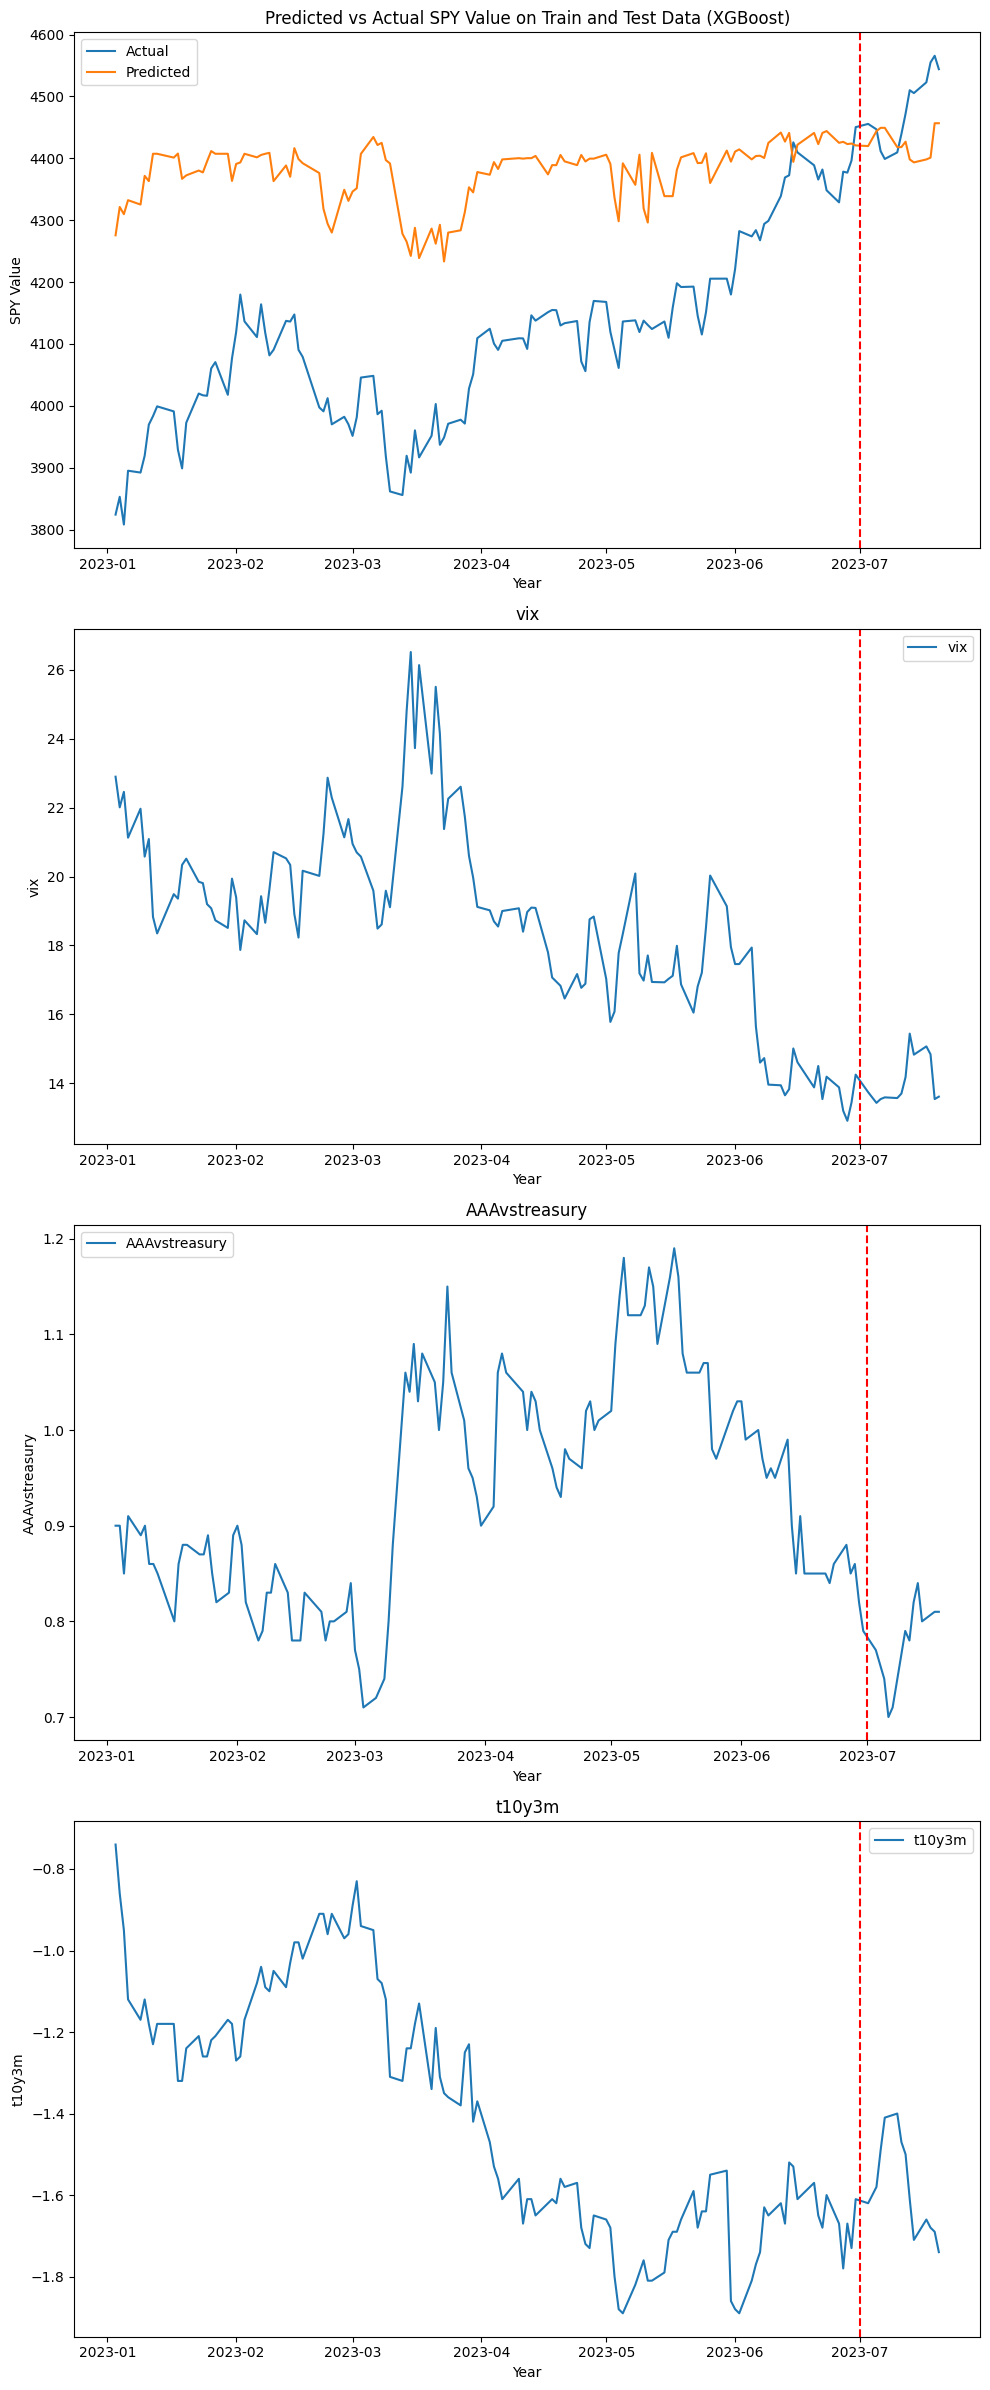

In [18]:
# Make predictions on all the data prior to splitting
y_pred = model.predict(X)

# Create a time index for plotting
time_index = range(len(y_pred))

# Get the dates from the 'spy_data' dataframe based on the index numbers for alignment
dates = spy_data['Date'].iloc[time_index]

# Create a single figure object
fig, axs = plt.subplots(4, 1, figsize=(10, 24))

# Plot the predicted vs actual values
axs[0].plot(dates, y, label='Actual')
axs[0].plot(dates, y_pred, label='Predicted')
axs[0].axvline(np.datetime64('2023-07-01'), color='red', linestyle='--')  # Vertical line for July 1, 2023, which corresponds to when the XGBoost model was trained
axs[0].set_xlabel('Year')
axs[0].set_ylabel('SPY Value')
axs[0].set_title('Predicted vs Actual SPY Value on Train and Test Data (XGBoost)') 
axs[0].legend()

# Plot vix
axs[1].plot(dates, X.vix, label='vix')
axs[1].axvline(np.datetime64('2023-07-01'), color='red', linestyle='--')  
axs[1].set_title('vix')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('vix')
axs[1].legend()

# Plot AAAvstreasury
axs[2].plot(dates, X.AAAvstreasury, label='AAAvstreasury')
axs[2].axvline(np.datetime64('2023-07-01'), color='red', linestyle='--')  
axs[2].set_title('AAAvstreasury')
axs[2].set_xlabel('Year')
axs[2].set_ylabel('AAAvstreasury')
axs[2].legend()

# Plot t10y3m
axs[3].plot(dates, X.t10y3m, label='t10y3m')
axs[3].axvline(np.datetime64('2023-07-01'), color='red', linestyle='--')  
axs[3].set_title('t10y3m')
axs[3].set_xlabel('Year')
axs[3].set_ylabel('t10y3m')
axs[3].legend()


plt.tight_layout()
plt.savefig('figures/validationfrom2023_predictedvsSPY_inclTrain.png', bbox_inches="tight", dpi=300)
plt.show()
